##Análise Exploratória de Dado

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/content/drive/MyDrive/trabalho2/data (1).csv')
df.head(2)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [ ]:
df.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


oi :)

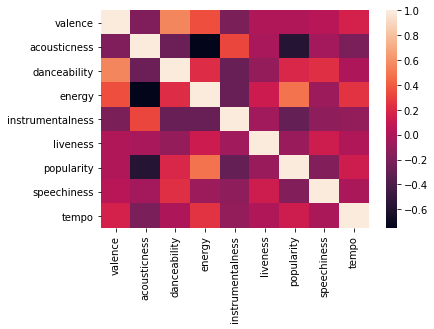

In [ ]:
sns.heatmap(df[['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'popularity', 'speechiness', 'tempo']].corr())

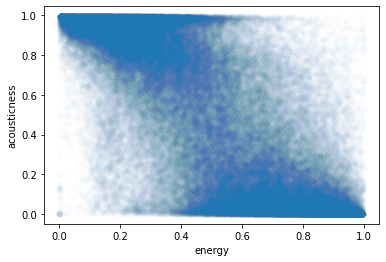

In [ ]:
sns.scatterplot(x='energy', y='acousticness', data=df, alpha=0.01)

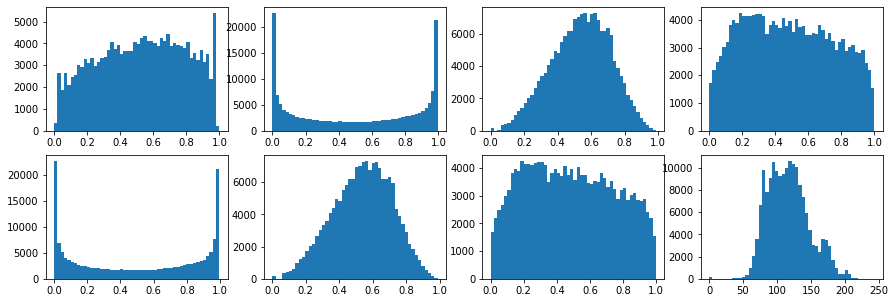

In [ ]:
fig, axs = plt.subplots(2,4)
fig.set_figheight(5)
fig.set_figwidth(15)

cols = ['valence', 'acousticness', 'danceability', 'energy', 'tempo', 'liveness', 'popularity', 'speechiness']

for i in range(2):
  for j in range(4):
    axs[i,j].hist(df[cols[i+j]], bins=50)

## Clustering Ward

In [6]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors, NearestCentroid
from sklearn.preprocessing import MinMaxScaler

Limpeza dos dados, selecionando as músicas com datas de lançamento a partir de 2010 e removendo músicas duplicadas

In [136]:
df80 = df[df['year'] >= 2010]
aux = df80.copy()

aux['name'] = aux['name'].str.replace(r'\sand\s', ' & ')
duplicates = aux.duplicated(subset=['artists', 'name'], keep=False)

most_popular_duplicates = aux[duplicates].groupby(by=['artists', 'name'])['popularity'].idxmax().values
duplicates_to_drop = aux.loc[duplicates & (~aux.index.isin(most_popular_duplicates))].index
df80.drop(duplicates_to_drop,inplace=True)

Remoção de algumas variáveis do dataset, a fim de manter apenas as colunas mais relacionadas a emoções e humor. 

In [196]:
df_cluster = df80.drop(['artists','name','acousticness','instrumentalness','speechiness','release_date','id','year','duration_ms','popularity', 'mode', 'key', 'liveness'],1)

Normalização do dados para aplicação do modelo

In [ ]:
scaler = MinMaxScaler()
df_transformed = scaler.fit_transform(df_cluster)
df_transformed

In [138]:
df_transformed.shape

(20601, 6)

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn import metrics

In [61]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sch.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

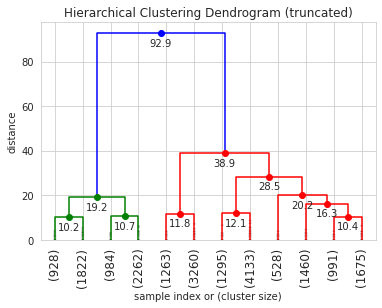

In [139]:
fancy_dendrogram(sch.linkage(df_transformed, method='ward'),
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,)
plt.show()

In [140]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model.fit(df_transformed)
labels = model.labels_

In [141]:
metrics.silhouette_score(df_transformed, labels, metric='euclidean') 

0.32867424036036175

In [142]:
metrics.calinski_harabasz_score(df_transformed, labels)

17372.94824841125

In [143]:
metrics.davies_bouldin_score(df_transformed, labels)

1.2335788372193823

In [166]:
df_cluster_final = df80
df_cluster_final['cluster']=labels
df_cluster_final[df_cluster_final['cluster']==3].sample(10)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,cluster
55515,0.514,2011,0.157000,['Maná'],0.648,291867,0.727,0,5etssK2rpk4SnHWWD1Q6xn,0.000006,2,0.1500,-6.761,1,Amor Clandestino,65,2011-04-11,0.0289,147.883,3
75120,0.415,2020,0.900000,['Taylor Swift'],0.596,208907,0.488,0,6KJqZcs9XDgVck7Lg9QOTC,0.000027,4,0.0910,-10.769,1,seven,74,2020-07-24,0.0274,94.926,3
18261,0.322,2013,0.025600,['Phillip Phillips'],0.606,210173,0.826,0,4rsW3WCZBGwhHfJWuHRwyT,0.000016,0,0.1170,-6.040,1,Home,68,2013-01-01,0.0307,121.040,3
37136,0.294,2013,0.032700,['Cody Jinks'],0.637,230827,0.475,0,38DNcm40OxQiMmNTFSwWeV,0.000093,9,0.1090,-7.868,1,Fast Hand,60,2013-06-18,0.0337,141.866,3
122832,0.509,2010,0.036800,['Surfer Blood'],0.567,234497,0.735,0,5ElF4NdnaSCHlJLCqHyy0u,0.000824,4,0.1490,-7.296,1,Floating Vibes,46,2010-01-19,0.0294,126.857,3
18468,0.434,2014,0.074900,['Sam Hunt'],0.579,229880,0.776,0,7aftSOGSOpSoIlVAQVBb71,0.000000,8,0.2390,-5.365,1,Break Up In A Small Town,69,2014-10-27,0.1730,136.044,3
17946,0.132,2011,0.004630,['Cage The Elephant'],0.457,211373,0.613,0,1Hb1IJ9bBCa6wo3fRtexnJ,0.000441,9,0.0711,-5.756,1,Shake Me Down,62,2011-01-10,0.0295,105.110,3
75168,0.497,2020,0.236000,['Surfaces'],0.765,212850,0.689,0,5Pgq1Gfeth2CuUhyCXwlfC,0.000007,6,0.1140,-5.616,1,Take It Easy,74,2020-02-28,0.0456,144.958,3
170208,0.481,2018,0.000055,['Palisades'],0.466,197835,0.864,0,7EEaV81pUNKvqsTrEHGoQH,0.000000,3,0.2340,-5.586,0,Erase The Pain,59,2018-12-28,0.0976,138.075,3
55615,0.206,2012,0.054800,['Chris Brown'],0.602,222307,0.691,0,18VfHIPaCo0s6FTi1Fnp6T,0.000000,7,0.1440,-5.197,0,Don't Wake Me Up,64,2012-07-03,0.0510,127.967,3


In [195]:
df_cluster_final[df_cluster_final['artists'].str.find('Nicki Minaj')!=-1]['cluster'].value_counts()

1    90
2     8
3     4
0     1
Name: cluster, dtype: int64

In [145]:
np.unique(model.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([4654, 5996, 4523, 5428]))

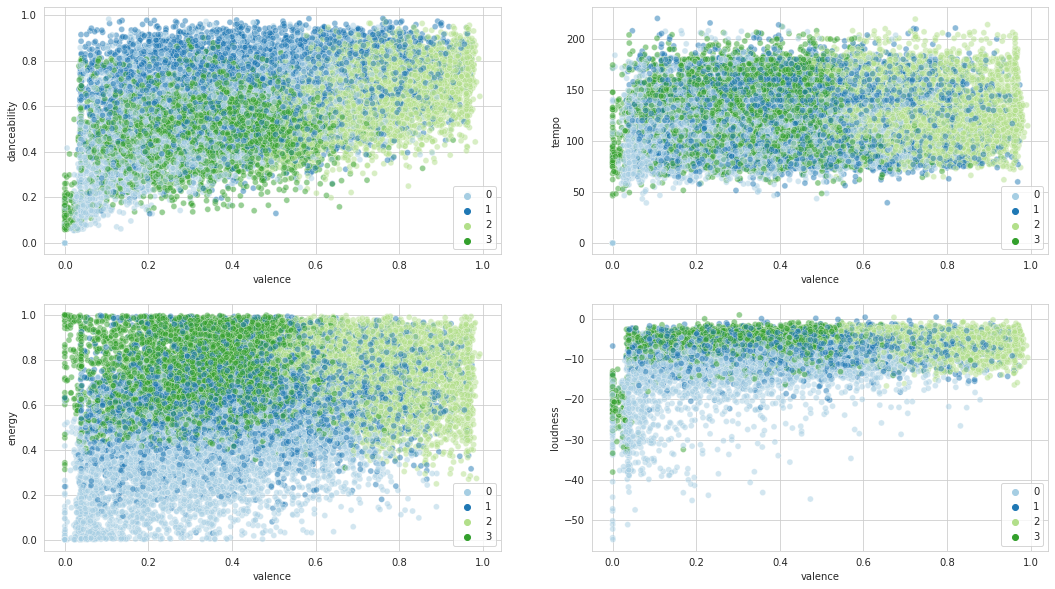

In [146]:
sns.set_style(style='whitegrid')
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(18)

cols = ['danceability', 'energy', 'tempo', 'loudness']

for i in range(2):
  for j in range(2):
    sns.scatterplot(x='valence', y=cols[j*2+i], data=df80, ax=axs[i,j], hue = labels,alpha=0.5, palette='Paired')